<a href="https://colab.research.google.com/github/harnalashok/classification/blob/main/7_higgs_boson_xgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Last amended: 26th June, 2021
Ref:
 1. 
 2. http://krasserm.github.io/2018/03/21/bayesian-optimization/

Objectives:
    1. Reading from hard-disk random samples of big-data
    2. Using PCA
    3. Pipelining with StandardScaler, PCA and xgboost
    4. Grid tuning of PCA and xgboost--Avoid data leakage
    5. Randomized search of parameters
    6. Bayes optimization
    7. Feature importance
    8. Genetic algorithm for tuning of parameters
    9. Find feature importance of any Black box estimator
       using Permutation 

See this file in github:
    7.higgs_pipeline_xgboostBayesOpt_simple.py
"""

## Install packages

In [2]:
# 0.0
# For skopt routines
! pip install scikit-optimize

# 0.1 For plotting skopt results
! pip install 'scikit-optimize[plots]'

     |████████████████████████████████| 102kB 7.7MB/s 


## About L1 and L2 regularization
Please see [this](https://towardsdatascience.com/regularization-in-machine-learning-connecting-the-dots-c6e030bfaddd) reference and [this](https://stats.stackexchange.com/questions/45643/why-l1-norm-for-sparse-models) one.

Regularization can be understood as a technique to improve the generalizability of a learned model.  A simpler model may underfit and will perform poorly with predictions. Just because two data points fit a line perfectly doesn’t mean that a third point will fall exactly on that line — in fact, it’s highly unlikely. One needs to move from simpler model to complex model to improve upon predictions. It is here that regularization helps by stopping us on the way and not allowing the model to be over-complex as to overfit the model.  

Simply put, regularization penalizes models that are more complex in favor of simpler models (ones with smaller regression coefficients) — but not at the expense of reducing predictive power.

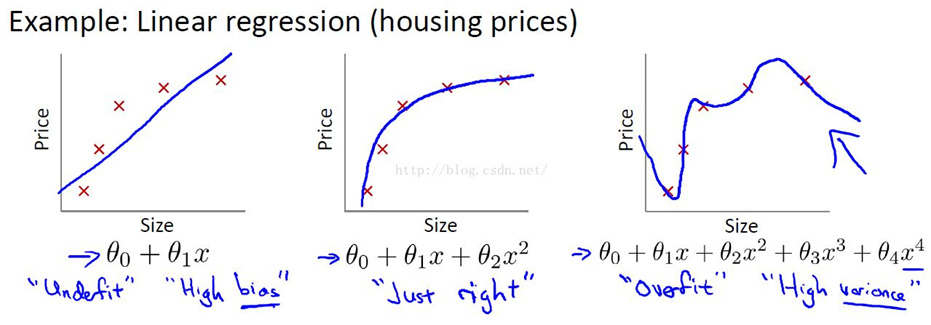

### Penalty terms

Regularization works by biasing data towards particular values (such as small values near zero). The bias is achieved by adding a tuning parameter to encourage those values:

> L1 regularization adds an L1 penalty equal to the absolute value of the magnitude of coefficients. In other words, it limits the size of the coefficients. L1 can yield sparse models (i.e. models with few coefficients); Some coefficients can become zero and eliminated. Lasso regression uses this method.

> L2 regularization adds an L2 penalty equal to the square of the magnitude of coefficients. L2 will not yield sparse models and all coefficients are shrunk by the same factor (none are eliminated). Ridge regression and SVMs use this method.

> Elastic nets combine L1 & L2 methods, but does add a second hyperparameter.


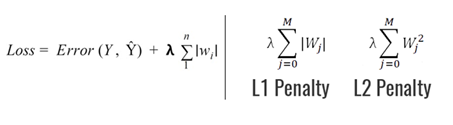

#### Elastic net

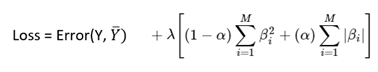

### Regularization how it works

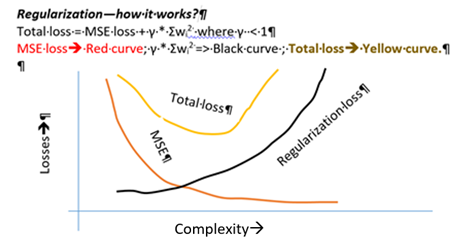

L1 penality can sometimes lead to a value of coefficients where one of them is zero (but this is not always true). L1 models are therefore sparse, easy to store (as some coefficients are zero) and can also indicate feature importance.

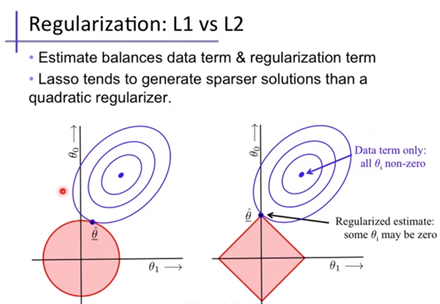

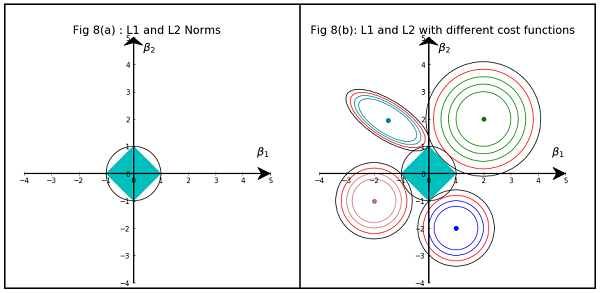

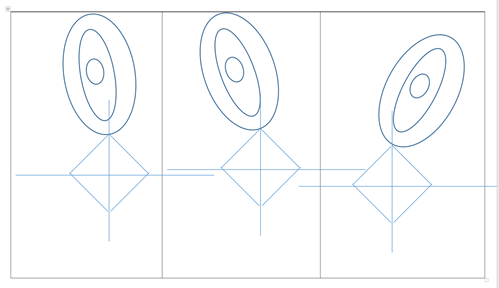

## Call libraries

In [3]:
# 1.0 Clear ipython memory
#%reset -f

# 1.1 Data manipulation and plotting modules
import numpy as np
import pandas as pd


# 1.2 Data pre-processing
#     z = (x-mean)/stdev
from sklearn.preprocessing import StandardScaler as ss

# 1.3 Dimensionality reduction and noise removal
from sklearn.decomposition import PCA

# 1.4 Data splitting and model parameter search
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# 1.5 Model pipelining
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# 1.6 Hyperparameter optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# 1.7.1
#     pip install scikit-optimize
#     pip install 'scikit-optimize[plots]'
#     Refer: https://github.com/scikit-optimize/scikit-optimize
#     conda install -c conda-forge scikit-optimize
from skopt import BayesSearchCV 
from skopt.space import Real, Categorical, Integer

# 1.8 Modeling modules
#     Call sklearn wrapper of xgboost
# """Scikit-Learn Wrapper interface for XGBoost."""
#  """Implementation of the Scikit-Learn API for XGBoost.
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn
# Stackoverflow:
# https://stackoverflow.com/a/34696477
# https://stackoverflow.com/a/46947191
# Install as: conda install -c anaconda py-xgboost
from xgboost.sklearn import XGBClassifier

In [6]:
# 1.9 Model evaluation metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix

# 1.10
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance

# 1.11 Permutation feature importance
from sklearn.inspection import permutation_importance

In [7]:
# 1.12 Misc
import time
import os
import gc
import random

# 1.13 Used in Randomized parameter search
from scipy.stats import uniform

In [8]:
# 1.14
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [9]:
# 1.15 Set option to dislay many rows
pd.set_option('display.max_columns', 100)

In [10]:
# 1.16 If you are using colab
#      Execute following code
#      to mount your gdrive

from google.colab import drive
# Path where to mount MyDrive
# We will mount it at /ashok
# This drive will be created
drive.mount('/ashok')


Mounted at /ashok


## Read Data
Simple processing and finally split data into train/test
(#2.0--#4.1)

#### Read a sample of data

We will read a sample of data from harddisk. Pandas has a facility not to read into RAM complete data but a random fraction of it.

In [19]:
################# BB. Read data randomly #################
# 2.0 Read random chunks of 10% of data

path = "/ashok/MyDrive/Colab_data_files/higgs_boson/"

# 2.1 Set working directory
#     to where data is
os.chdir(path)
os.listdir()


# 2.2 Our data file
tr_f = "training.csv.zip"


# 2.3 Total number of rows: 250001
#     But we will read 40% of data randomly
total_lines = 250000
num_lines = 0.4 * total_lines    # 40% of data


# 2.4 Read randomly 'p' fraction of files
#     Ref: https://stackoverflow.com/a/48589768

p = num_lines/total_lines  # fraction of lines to read (40%)

# 2.4.1 How to pick up random rows from hard-disk
#       without first loading the complete file in RAM
#       Toss a coin:
#           At each row, toss a biased-coin: 60%->Head, 40%->tail
#           If tail comes, select the row else not.
#           Toss a coin: random.random()
#           Head occurs if value > 0.6 else it is tail
#
#       We do not toss the coin for header row. Keep the header

data = pd.read_csv(
         tr_f,
         header=0,   # First row is header-row
         # 'and' operator returns True if both values are True
         #  random.random() returns values between (0,1)
         #  No of rows skipped will be around 60% of total
         skiprows=lambda i: (i >0 ) and (random.random() > p)    # (i>0) implies skip first header row
         )



['training.csv.zip']

In [20]:
# 3.0 Explore data
print("\n Shape")
data.shape                # 100039, 33)
print("\n\n Columns")
data.columns.values       # Label column is the last one
print("\n")

# 3.0.1
print("\n\nTarget distribution")
data.Label.value_counts()  # Classes are not unbalanced
                           # Binary data
                           #  b: 65558 , s: 34242
# 3.0.2
print("\n\nData types")                        
data.dtypes.value_counts()  # Label column is of object type
print("\n")
data.head(3)


 Shape


(99492, 33)



 Columns


array(['EventId', 'DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet',
       'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep',
       'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau',
       'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt',
       'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta',
       'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 'PRI_met_sumet',
       'PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta',
       'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi',
       'PRI_jet_all_pt', 'Weight', 'Label'], dtype=object)





Target distribution


b    65281
s    34211
Name: Label, dtype: int64



Data types


float64    30
int64       2
object      1
dtype: int64

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,41.928,197.760,1.582,1.396,0.200,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.15,0.444,46.062,1.240,-2.475,113.497,0.002653,s
1,100003,143.905,81.417,80.943,0.414,-999.000,-999.000,-999.000,3.310,0.414,75.968,2.354,-1.285,-999.000,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,-999.000,-999.00,-999.000,-999.000,-999.000,-999.000,-0.000,5.446378,b
2,100011,114.744,10.286,75.712,30.816,2.563,252.599,-1.401,2.888,36.745,239.804,1.061,1.364,0.769,35.976,-0.669,-0.342,38.188,-0.165,2.502,22.385,2.148,290.547,3,76.773,-0.79,0.303,56.876,1.773,-2.079,165.640,0.307170,b


In [21]:
# 3.1 Examine data statistics
data.describe()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight
count,99492.000000,99492.000000,99492.00000,99492.000000,99492.000000,99492.000000,99492.000000,99492.000000,99492.000000,99492.000000,99492.000000,99492.000000,99492.000000,99492.000000,99492.000000,99492.000000,99492.000000,99492.000000,99492.000000,99492.000000,99492.000000,99492.000000,99492.000000,99492.000000,99492.000000,99492.000000,99492.000000,99492.000000,99492.000000,99492.000000,99492.000000,99492.000000
mean,224510.409410,-48.467539,49.09352,81.163578,57.800636,-708.618835,-601.395187,-709.561175,2.373632,18.920657,158.296283,1.436738,-0.125474,-709.183450,38.689642,-0.007891,-0.011263,46.609987,-0.017299,0.047201,41.606504,-0.012402,209.682844,0.979737,-347.442014,-398.352938,-398.351444,-692.643781,-709.313100,-709.316538,72.996655,1.644649
std,72166.457472,405.929252,35.26691,40.784749,62.990906,454.391444,658.118812,452.919999,0.783799,21.474413,115.016607,0.839588,1.194487,453.507004,22.420582,1.216940,1.815245,21.806706,1.268936,1.815791,31.968650,1.808983,125.785207,0.976651,532.640784,489.150070,489.151360,479.693809,453.305395,453.299751,97.459839,1.875404
min,100000.000000,-999.000000,0.00000,7.330000,0.000000,-999.000000,-999.000000,-999.000000,0.228000,0.000000,46.212000,0.047000,-1.414000,-999.000000,20.000000,-2.499000,-3.142000,26.001000,-2.494000,-3.142000,0.155000,-3.141000,13.678000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.001502
25%,162228.500000,78.269750,19.16775,59.402000,14.140750,-999.000000,-999.000000,-999.000000,1.809000,2.834000,77.481000,0.887000,-1.371000,-999.000000,24.581000,-0.929000,-1.573000,32.369000,-1.015000,-1.519000,21.429000,-1.572000,123.059250,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-0.000000,0.018636
50%,224183.000000,105.135000,46.28950,73.773500,38.418000,-999.000000,-999.000000,-999.000000,2.494000,12.427000,120.679500,1.279000,-0.335000,-999.000000,31.746500,-0.016000,-0.046000,40.524500,-0.047000,0.089000,34.837000,-0.026000,179.913000,1.000000,38.964000,-1.869000,-2.089000,-999.000000,-999.000000,-999.000000,40.520000,1.146767
75%,287054.500000,130.716000,73.45650,92.336500,79.249500,0.482000,82.976500,-4.660750,2.962000,27.641000,200.346000,1.774000,1.229000,0.000000,44.907250,0.903000,1.558000,53.380000,0.971000,1.620250,51.930000,1.551250,263.091250,2.000000,75.567250,0.428000,0.521000,33.671250,-2.436750,-2.267000,110.091500,2.406894
max,349997.000000,1192.026000,594.28700,1034.205000,673.809000,8.301000,4543.913000,16.648000,5.626000,466.525000,1703.752000,19.773000,1.414000,1.000000,622.862000,2.497000,3.142000,447.878000,2.502000,3.142000,536.468000,3.142000,1723.087000,3.000000,755.235000,4.492000,3.141000,706.672000,4.500000,3.141000,1633.433000,7.821961


In [22]:
# 3.2 We do not need Id column and Weight column
data.drop(columns = ['EventId','Weight'],inplace = True  )

In [23]:
# 3.3 Divide data into predictors and target
#     First 30 columns are predictors

X = data.iloc[ :, 0:30]
X.head(2)

# 3.3.1 30th index or 31st column is target
print("\n\nTarget,y, values")
y = data.iloc[ : , 30]
y.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,1.582,1.396,0.2,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.15,0.444,46.062,1.24,-2.475,113.497
1,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,75.968,2.354,-1.285,-999.0,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,-999.000,-999.00,-999.000,-999.000,-999.00,-999.000,-0.000




Target,y, values


0    s
1    b
2    b
3    b
4    b
Name: Label, dtype: object

In [24]:
# 3.3.2 Can we change datatype to float32 ?
#       Check.
X.min().min()           # -999.0
X.max().max()           # 4543.913

# 3.3.3  Save memory
X = X.astype('float32')


-999.0

4543.913

In [25]:
# 3.4 Transform label data to '1' and '0'
#    'map' works element-wise on a Series.
y = y.map({'b':1, 's' : 0})
y.dtype           # int64


# 3.5 Store column names somewhere
#     for use in feature importance

colnames = X.columns.tolist()


dtype('int64')

#### Split data into train/test

In [26]:

# 4. Split dataset into train and validation parts
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.35,
                                                    shuffle = True,
                                                    stratify = y
                                                    )

# 4.1
X_train.shape        # (65025, 30)
X_test.shape         # (35014, 30)
y_train.shape        # (65025,)
y_test.shape         # (35014,)

(64669, 30)

(34823, 30)

(64669,)

(34823,)

## Create a pipeline
Create a pipeline for data processing and modeling. We will then use `Grid Search` and `Random Search` to find best set of parameters for this pipeline.

In [27]:
################# CC. Create pipeline #################
#### Pipe using XGBoost


# 5.0 Pipeline steps
# steps: List of (name, transform) tuples
#       (implementing fit/transform) that are
#       chained, in the order in which they
#       are chained, with the last object an
#       estimator.
#      Format: [(name, transformer), (name, transformer)..(name, estimator)]

steps_xg = [('sts', ss() ),
            ('pca', PCA()),
            ('xg',  XGBClassifier(silent = False,
                                  n_jobs=3)        # Specify other parameters here
            )
            ]

# 5.1  Instantiate Pipeline object

pipe_xg = Pipeline(steps_xg)

# 5.2 Another way to create pipeline:
#     Not used below

#pipe_xg1 = make_pipeline (
#                          ss(),
#                          PCA(),
#                          XGBClassifier(silent = False,
#                                        n_jobs=2)
#                          )



## Cross Validation
Understanding cross-validation

### Part picture

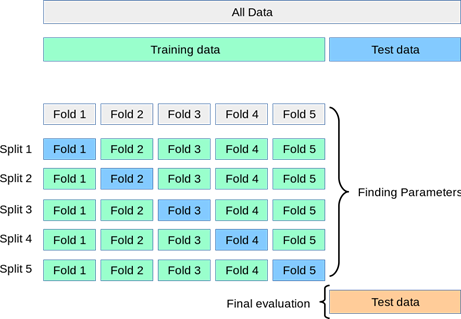

### Full picture

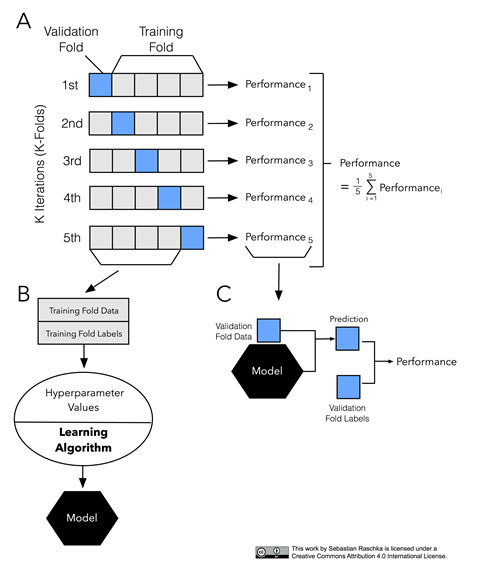

## Grid Search vs Random Search
See this [link](https://stats.stackexchange.com/a/209409) and this [link](https://medium.com/@jackstalfort/hyperparameter-tuning-using-grid-search-and-random-search-f8750a464b35).

### How they work?

Green curves show true objective function as a function of the given parameter. While Grid search misses the Objective function completely, Random Search does not. (We are assuming here that one parameter is important and the other not. So the Objective function depends completely on the values of one parameter.) 

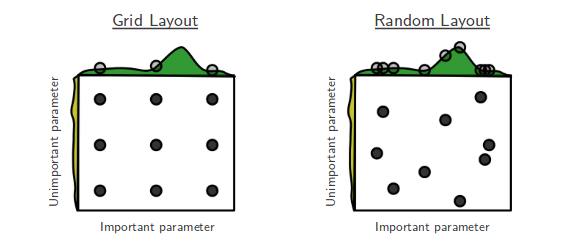

Random search can still miss the global optimum completely, as in the following illustration.

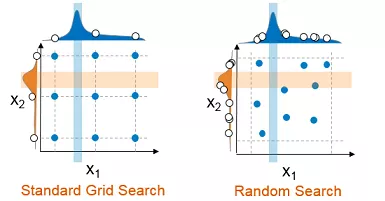

Intuitively, both for Grid Search as also for Random Search, it would be more efficient to choose the next hyperparameter combination according to past combinations performances. A mutual drawback of both these approaches is that the method loses efficiency if the understanding or importance of model parameters are not known beforehand. That is, we start tuning both important as also unimportant parameters thus wasting computer resources. 

In [ ]:

##################$$$$$$$$$$$#####################
## Jump now to
##   Either:   Grid Search (DD)             para 6
##       Or:   Random Search (EE)
##       Or:   Bayesian Optimization (GG)
##       Or:   Evolutionary Algorithm (HH)
##################$$$$$$$$$$$#####################

# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

### Grid Search code to discover best pipeline parameters
For a cmprehensive coverage of xgboost parameters and what they imply, please see [here](https://xgboost.readthedocs.io/en/latest/parameter.html) and also [here](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) .

In [28]:
##################### DD. Grid Search #################

# 6.  Specify xgboost parameter-range
# 6.1 Dictionary of parameters (16 combinations)
#     Syntax: {
#              'transformerName__parameterName' : [ <listOfValues> ]
#              }
#
# 6.2 What parameters in the pipe are available for tuning

print("\n\n--Which parameters can be tuned?--\n\n")
pipe_xg.get_params()




--Which parameters can be tuned?--




{'memory': None,
 'pca': PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
     svd_solver='auto', tol=0.0, whiten=False),
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': None,
 'pca__random_state': None,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'steps': [('sts', StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('pca',
   PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
       svd_solver='auto', tol=0.0, whiten=False)),
  ('xg', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bynode=1, colsample_bytree=1, gamma=0,
                 learning_rate=0.1, max_delta_step=0, max_depth=3,
                 min_child_weight=1, missing=None, n_estimators=100, n_jobs=3,
                 nthread=None, objective='binary:logistic', random_state=0,
                 reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               

#### Define parameter space
Now that we know which parameters can be tuned, specify parameter space

In [29]:
# 6.3 Define dictionary
parameters = {'xg__learning_rate':  [0.03, 0.05], # learning rate decides what percentage
                                                  #  of error is to be fitted by
                                                  #   by next boosted tree.
                                                  # See this answer in stackoverflow:
                                                  # https://stats.stackexchange.com/questions/354484/why-does-xgboost-have-a-learning-rate
                                                  # Coefficients of boosted trees decide,
                                                  #  in the overall model or scheme, how much importance
                                                  #   each boosted tree shall have. Values of these
                                                  #    Coefficients are calculated by modeling
                                                  #     algorithm and unlike learning rate are
                                                  #      not hyperparameters. These Coefficients
                                                  #       get adjusted by l1 and l2 parameters
              'xg__n_estimators':   [200,  300],  # Number of boosted trees to fit
                                                  # l1 and l2 specifications will change
                                                  # the values of coeff of boosted trees
                                                  # but not their numbers

              'xg__max_depth':      [4,6],
              'pca__n_components' : [25,30],
              'xg__booster': ['gbtree','gblinear']
              }                               # Total: 2 * 2 * 2 * 2



#### Instantiate GridSearchCV class

In [30]:
# 7  Grid Search (16 * 2) iterations
#    Create Grid Search object first with all necessary
#    specifications. Note that data, X, as yet is not specified

#    Data Leakage and pipelining:
#    Pipeline avoids data leakage during GridSearch
#    See this: https://towardsdatascience.com/a-simple-example-of-pipeline-in-machine-learning-with-scikit-learn-e726ffbb6976

clf = GridSearchCV(pipe_xg,            # pipeline object
                   parameters,         # possible parameters
                   n_jobs = 2,         # USe parallel cpu threads
                   cv =2 ,             # No of folds
                   verbose =1,         # Higher the value, more the verbosity
                   scoring = ['accuracy', 'roc_auc'],  # Metrics for performance
                   refit = 'roc_auc'   # Refitting final model on what parameters?
                                       # Those which maximise auc
                   )

## 7.1 Delete objects not needed
#      We need X_train, y_train, X_test, y_test
del X
del data
del y
gc.collect()

187

#### Model fitting

In [31]:
# 7.2. Start fitting pipeline to data
print("\n\n--Takes time...---\n")
start = time.time()
clf.fit(X_train, y_train)
end = time.time()
print()
(end - start)/60               # 25 minutes



--Takes time...---

Fitting 2 folds for each of 32 candidates, totalling 64 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 12.7min
[Parallel(n_jobs=2)]: Done  64 out of  64 | elapsed: 14.8min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('sts',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('xg',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                 

16.08180900812149

#### Performance Scores

In [32]:
# 7.3
f"Best score: {clf.best_score_} "            # 'Best score: 0.8804992694908675 '

# 7.3.1
print()
f"Best parameter set {clf.best_params_}"

'Best score: 0.883913523261875 '

"Best parameter set {'pca__n_components': 30, 'xg__booster': 'gbtree', 'xg__learning_rate': 0.05, 'xg__max_depth': 6, 'xg__n_estimators': 300}"

--Few predictions--



array([1, 1, 0, 1])



--Accuracy Score--



81.94871205812251



--Confusion Matrix--



array([[ 8392,  3582],
       [ 2704, 20145]])



--F1 Score pos-label: 1--



0.8650377877018207



--F1 Score pos-label: 0--



0.7275249241439098



--ROC curve--



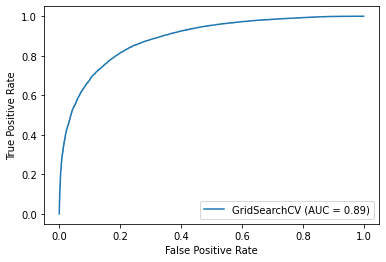

In [33]:
# 7.4. Make predictions using the best returned model
y_pred = clf.predict(X_test)
print("--Few predictions--\n")
y_pred[:4]

# 7.5 Accuracy score
print("\n\n--Accuracy Score--\n")
accuracy = accuracy_score(y_test, y_pred)
accuracy * 100.0             # 'Accuracy: 82.11165535218126'

# 7.6 Confusion matrix
print("\n\n--Confusion Matrix--\n")
confusion_matrix( y_test,y_pred)

# 7.7 F1 score
print("\n\n--F1 Score pos-label: 1--\n")
f1_score(y_test,y_pred, pos_label = 1)      # 0.8664199696263183

print("\n\n--F1 Score pos-label: 0--\n")
f1_score(y_test,y_pred, pos_label = 0)      # 0.729313857223354

# 7.8 ROC curve and get AUC
print("\n\n--ROC curve--\n")
_=plot_roc_curve(clf, X_test, y_test)

#### Feature importance

In [34]:
# 7.9 Get feature importances from GridSearchCV best fitted 'xg' model
#     See stackoverflow: https://stackoverflow.com/q/48377296

print("\n\n--How many features--\n")
clf.best_estimator_.named_steps["xg"].feature_importances_.shape

# 7.9.1
print("\n\n---Feature importances---\n")
clf.best_estimator_.named_steps["xg"].feature_importances_



--How many features--



(30,)



---Feature importances---



array([0.10217336, 0.02948259, 0.16680731, 0.05048785, 0.07309435,
       0.02203962, 0.00929078, 0.04176404, 0.00974424, 0.04446022,
       0.00835691, 0.04905209, 0.01731276, 0.02408527, 0.02222793,
       0.02090293, 0.04737613, 0.01379679, 0.04669188, 0.06796141,
       0.02448587, 0.01451604, 0.01082605, 0.01162008, 0.01479353,
       0.01145088, 0.01105778, 0.00973645, 0.01590885, 0.00849608],
      dtype=float32)

In [35]:
# 7.10 Create a dataframe of feature importances
#      with names of columns and sorted by feature-imp

imp_values = clf.best_estimator_.named_steps["xg"].feature_importances_
df_imp = pd.DataFrame(
                      data = imp_values,
                      index = colnames,
                      columns = ["imp"]
                      ).sort_values(by = 'imp')

# 7.10.1
df_imp

,imp
DER_pt_ratio_lep_tau,0.008357
PRI_jet_all_pt,0.008496
DER_prodeta_jet_jet,0.009291
PRI_jet_subleading_eta,0.009736
DER_pt_tot,0.009744
PRI_jet_num,0.010826
PRI_jet_subleading_pt,0.011058
PRI_jet_leading_phi,0.011451
PRI_jet_leading_pt,0.011620
PRI_lep_eta,0.013797


In [36]:
# 7.11 First five columns with least feature importance are:

list(df_imp.index.values[:5])

['DER_pt_ratio_lep_tau',
 'PRI_jet_all_pt',
 'DER_prodeta_jet_jet',
 'PRI_jet_subleading_eta',
 'DER_pt_tot']

#### Retraining model with imp features
(Can be avoided in the class)

In [ ]:
# 8.0 Let us drop these from X_train and X_test
Xtrain = X_train.drop(columns = list(df_imp.index.values[:5]))
Xtest = X_test.drop(columns = list(df_imp.index.values[:5]))

# 8.1 Build model again with reduced dataset
clf_dr = GridSearchCV(pipe_xg,            # pipeline object
                      parameters,         # possible parameters
                      n_jobs = 2,         # USe parallel cpu threads
                      cv =3 ,             # No of folds
                      verbose =2,         # Higher the value, more the verbosity
                      scoring = ['accuracy', 'roc_auc'],  # Metrics for performance
                      refit = 'roc_auc'   # Refitting final model on what parameters?
                                       # Those which maximise auc
                     )

# 8.2
start = time.time()
clf_dr.fit(Xtrain, y_train)
end = time.time()
(end - start)/60               # 25 minutes

# 8.3 Make predictions
y_pred_dr = clf_dr.predict(Xtest)

# 8.4 Compare results.
#      Results may be marginally better
f1_score(y_test,y_pred_dr, pos_label = 1)      # 0.8664199696263183
f1_score(y_test,y_pred_dr, pos_label = 0)      # 0.729313857223354
f1_score(y_test,y_pred, pos_label = 1)      # 0.8664199696263183
f1_score(y_test,y_pred, pos_label = 0)      # 0.729313857223354
##################################


### Random Search code to discover best pipeline parameters

#### Parameter space
Define parameter space

In [ ]:
##################### EE. Randomized Search #################

# Tune parameters using randomized search
# 9.0 Hyperparameters to tune and their ranges
parameters = {'xg__learning_rate':  uniform(0, 1),
              'xg__n_estimators':   range(50,300),
              'xg__max_depth':      range(3,10),
              'pca__n_components' : range(20,30)}

#### Instantiate RandomSearchCV class

In [ ]:
# 9.1 Tune parameters using random search
#     Create the object first

rs = RandomizedSearchCV(
                          pipe_xg,
                          param_distributions=parameters,
                          scoring= ['roc_auc', 'accuracy'],
                          n_iter=4,           # Max combination of
                                              # parameter to try. Default = 10
                          verbose = 1,
                          refit = 'roc_auc',
                          n_jobs = 2,          # Use parallel cpu threads
                          cv = 2               # No of folds.
                                              # So n_iter * cv combinations
                        )


#### Start training RandomSearchCV object

In [ ]:
# 9.2 Run random search for 25 iterations. 21 minutes:

start = time.time()
rs.fit(X_train, y_train)
end = time.time()
print()
(end - start)/60   # 4 minutes

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   8 out of   8 | elapsed:  2.7min finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('sts',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('pca',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=None,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('xg',
                                              XGBClassifier(base_score=0.5,
                              

3.9122904976209005

#### Performance scores

In [ ]:
# 9.3 Evaluate
f"Best score: {rs.best_score_} " ;print()           # 'Best score: 0.8780097831252602 '
f"Best parameter set: {rs.best_params_} " ; print()


# 9.4 Make predictions from the best returned model
y_pred = rs.predict(X_test)


# 9.5 Accuracy and f1_score
accuracy = accuracy_score(y_test, y_pred)
f"Accuracy: {accuracy * 100.0}"   ; print()      # 'Accuracy: 82.0142648448913'
f"f1 score: {f1_score(y_test,y_pred, pos_label = 1)}" ; print()     # 0.8655661892221722


'Best score: 0.8790935489425076 '

"Best parameter set: {'pca__n_components': 29, 'xg__learning_rate': 0.018135165929190067, 'xg__max_depth': 8, 'xg__n_estimators': 195} "

'Accuracy: 81.28604876934499'

'f1 score: 0.8604106321349464'

## Bayesian Optimization
Please see this [quora](https://www.quora.com/How-does-Bayesian-optimization-work) answer.

### Understanding Bayesian optimization process

This is the idea: Sample some input-outputs (less than 10) and use them to guess the true loss function with something called a `'Gaussian Process'` (or ‘GP’ here). Then use that guessed function to determine where to evaluate next. Evaluate that point, add it to our set of input-outputs and infer the guessed function once again. Repeat this until you've exhausted your budget of evaluations (ie no of iterations or some other stopping criteria). If the GP is any good at guessing the true function, we’ll do better than random sampling.

If you don't know what a GP is, I can tell you the important pieces for our purposes. It's way of inferring a function (like the one we see above) from samples of its inputs and outputs. Not only that, it also provides a distribution over the outputs. So when you guess the function output at some given x
, the GP will also tell us the probability of finding it within given ranges. 

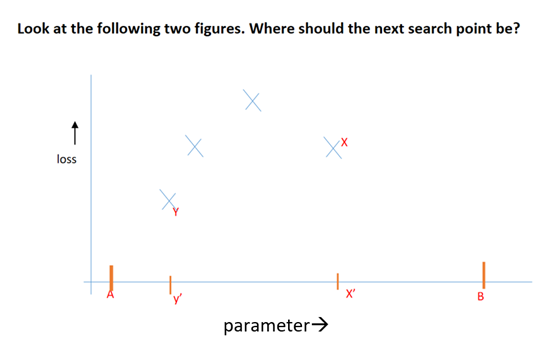

<i>Figure 1</i>: Where should the next search point be? Should it be between points X’and B, or between Y’ and A where there is not much space left. Maybe loss Y cannot come down to that extent. Be <b>explorative</b> than <b>exploitative</b>.

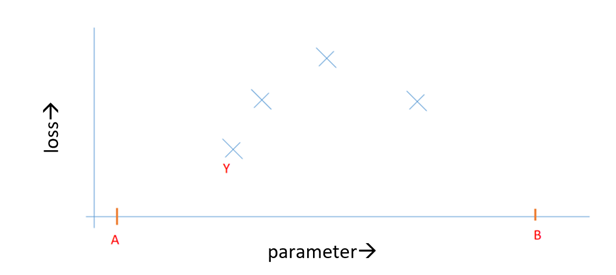

<i>Figure 2</i>: Where should the next parameter search be? Answer: On the left: Between Y and A. There is sufficient gap for Y to be able to still come down. Be <b>exploitative</b> than <b>explorative</b>.

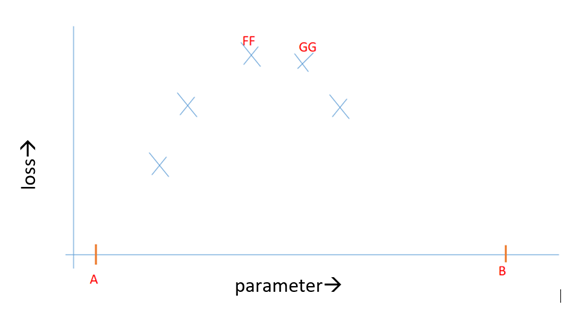

<i>Figure 3</i>: Should there be parameter search between points FF and GG. That depends upon two hyperparameters of Gaussian process: `Smoothness` and `Amplitude`. Or in other words, how smooth and how high/low a curve can permitted to be between two adjacent points. If large `Amplitude` is permitted and less `Smoothness` is tolerated, then search for parameter value will also be conducted between these two points. Below are samples drawn from a GP with various kernel parameters.

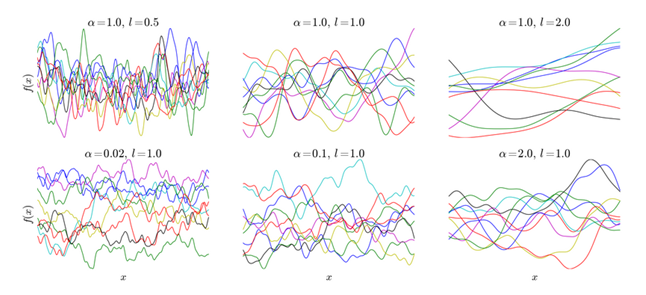

To do the bayesian parameter tuning, we use the BayesSearchCV class of scikit-optimize. It works basically as a drop-in replacement for `GridSearchCV` and `RandomSearchCV` and generally we get better results with it. 

In the following coe,  we define the BayesSearchCV object, and write a short convenience function that will be used during optimization to output current status of the tuning. Locally we have access to more cores and run with n_jobs=4 for the classifier, and n_jobs=6 for the BayesSearchCV object.

### Bayesian Search Code
Please see this [link](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html)

#### Parameter search space

In [ ]:
# 10.0 Laydown search space of parameters     
# https://www.kaggle.com/nanomathias/bayesian-optimization-of-xgboost-lb-0-9769

params={
         'min_child_weight': Integer(0, 50),
         'max_depth': Integer(1, 10),
         'subsample': (0.5, 1.0, 'uniform'),
         'colsample_bytree': Real(0.5, 1.0, 'uniform'),
         'reg_lambda':Real(1e-5,100,prior = 'log-uniform'),
         'reg_alpha': Real(1e-5,100,prior= 'log-uniform'),
         'gamma': (1e-9, 0.5, 'log-uniform'),
         'learning-rate': Real(0.01,0.2,prior='log-uniform'),
         'scale_pos_weight': (1e-6, 500, 'log-uniform'),
         'n_estimators': Integer(50, 100)
        }

#### Instantaite Bayesian Search tuner
And also define a callback function to print tuning status after each iteration


In [ ]:
# 10.1 Define our classifier:
bayes_tuner=BayesSearchCV(
                            XGBClassifier(
                                            n_jobs = 1,
                                            objective = 'binary:logistic',
                                            eval_metric = 'auc',
                                            silent=1,
                                            tree_method='approx'
                                            ),
                            params,
                            n_iter=5,              # No of parameter settings that are tried 
                            scoring='roc_auc',     # List of scores CANNOT be used
                            cv = StratifiedKFold(
                                                  n_splits=3,
                                                  shuffle=True,
                                                  random_state=42
                                                ),
                            refit = True, # Refit the best estimator so as to make predictions
                            verbose = 1
                    )


In [ ]:
# 10.2 This function is called after each parameter
#      fitting to print current status:

def status_print(optim_result):
  """Status callback durring bayesian hyperparameter search"""

  # 10.2.1 Get all the models tested so far in DataFrame format
  # cv_results_: A dict with keys as column headers and
  #              values as columns
  #        model_results dataframe is not being printed
  model_results = pd.DataFrame(bayes_tuner.cv_results_)    
  
  # 10.2.2 Get current parameters and the best parameters   
  # best_params_: A dict of parameter settings that 
  #               give the best results on the hold out data. 
  best_params = pd.Series(bayes_tuner.best_params_)
  
  print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(model_results),
        np.round(bayes_tuner.best_score_, 4),  # Score of best_estimator on the left out data.
        bayes_tuner.best_params_
    ))

#### Begin parameter tuning
And also print results

In [ ]:
# 11.0 Begin parameter tuning

start = time.time()
res=bayes_tuner.fit(
                      X_train,
                      y_train,
                      callback=status_print
                    )

end = time.time()
(end - start)/60   # 3 minutes on Colab

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   38.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model #1
Best ROC-AUC: 0.897
Best params: OrderedDict([('colsample_bytree', 0.7926526778312502), ('gamma', 0.005404733585121512), ('learning-rate', 0.03657814849895384), ('max_depth', 8), ('min_child_weight', 49), ('n_estimators', 62), ('reg_alpha', 0.0001584016305168668), ('reg_lambda', 0.439563473868956), ('scale_pos_weight', 331), ('subsample', 0.9310816048630326)])

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model #2
Best ROC-AUC: 0.897
Best params: OrderedDict([('colsample_bytree', 0.7926526778312502), ('gamma', 0.005404733585121512), ('learning-rate', 0.03657814849895384), ('max_depth', 8), ('min_child_weight', 49), ('n_estimators', 62), ('reg_alpha', 0.0001584016305168668), ('reg_lambda', 0.439563473868956), ('scale_pos_weight', 331), ('subsample', 0.9310816048630326)])

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   48.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model #3
Best ROC-AUC: 0.8989
Best params: OrderedDict([('colsample_bytree', 0.9646386298141321), ('gamma', 0.0037475981648393154), ('learning-rate', 0.0236932145625659), ('max_depth', 6), ('min_child_weight', 8), ('n_estimators', 89), ('reg_alpha', 0.0008292122132111558), ('reg_lambda', 0.01315348509562451), ('scale_pos_weight', 261), ('subsample', 0.8786062661745927)])

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model #4
Best ROC-AUC: 0.8989
Best params: OrderedDict([('colsample_bytree', 0.9646386298141321), ('gamma', 0.0037475981648393154), ('learning-rate', 0.0236932145625659), ('max_depth', 6), ('min_child_weight', 8), ('n_estimators', 89), ('reg_alpha', 0.0008292122132111558), ('reg_lambda', 0.01315348509562451), ('scale_pos_weight', 261), ('subsample', 0.8786062661745927)])

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   55.9s finished


Model #5
Best ROC-AUC: 0.9023
Best params: OrderedDict([('colsample_bytree', 0.9651371326440095), ('gamma', 9.126679387443308e-06), ('learning-rate', 0.12079311975920973), ('max_depth', 7), ('min_child_weight', 4), ('n_estimators', 85), ('reg_alpha', 0.2827217232089928), ('reg_lambda', 0.00027194569610679124), ('scale_pos_weight', 21), ('subsample', 0.8458752398975037)])



3.6468110124270123

## Extra
This code is not tested

In [ ]:
############### FF. Fitting parameters in our model ##############
###############    Model Importance   #################

# 9. Model with parameters of grid search
model_gs = XGBClassifier(
                    learning_rate = clf.best_params_['xg__learning_rate'],
                    max_depth = clf.best_params_['xg__max_depth'],
                    n_estimators=clf.best_params_['xg__max_depth']
                    )

# 9.1 Model with parameters of random search
model_rs = XGBClassifier(
                    learning_rate = rs.best_params_['xg__learning_rate'],
                    max_depth = rs.best_params_['xg__max_depth'],
                    n_estimators=rs.best_params_['xg__max_depth']
                    )


# 9.2 Modeling with both parameters
start = time.time()
model_gs.fit(X_train, y_train)
model_rs.fit(X_train, y_train)
end = time.time()
(end - start)/60


# 9.3 Predictions with both models
y_pred_gs = model_gs.predict(X_test)
y_pred_rs = model_rs.predict(X_test)


# 9.4 Accuracy from both models
accuracy_gs = accuracy_score(y_test, y_pred_gs)
accuracy_rs = accuracy_score(y_test, y_pred_rs)
accuracy_gs
accuracy_rs


In [ ]:
#!pip install PyQt5
import PyQt5
%matplotlib qt5
rs.feature_importances_

# 10.1.1 Importance type: 'weight'
plot_importance(
                rs,
                importance_type = 'weight'   # default
                )

In [ ]:
# 10.1 Plt now

%matplotlib qt5
rs.feature_importances_

# 10.1.1 Importance type: 'weight'
plot_importance(
                rs,
                importance_type = 'weight'   # default
                )
# 10.1.2 Importance type: 'gain'
#        # Normally use this
plot_importance(
                model_rs,
                importance_type = 'gain', 
                title = "Feature impt by gain"
                )
plt.show()

# 10.1 Print feature importance
#      https://stackoverflow.com/a/52777909
#      https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7
"""
importance_type

    ‘weight’ -      the number of times a feature is used to split the data across all trees.
    ‘gain’ -        the average gain across all splits the feature is used in.
    ‘cover’ -       the average coverage across all splits the feature is used in.
    ‘total_gain’ -  the total gain across all splits the feature is used in.
    ‘total_cover’ - the total coverage across all splits the feature is used in.

"""
# 11.0 Get results in a sorted DataFrame
feature_important = model_gs.get_booster().get_score(importance_type='weight')
feature_important
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values,
                    index=keys,
                    columns=["score"]).            \
                        sort_values(               \
                                     by = "score", \
                                    ascending=False)

# 11.1 Compare the results in the following DataFrame
#      with that obtained using PermutationImportance
#      of eli5 below.
                            
data

In [ ]:
# 10.1 Plt now

%matplotlib qt5
model_gs.feature_importances_
model_rs.feature_importances_
# 10.1.1 Importance type: 'weight'
plot_importance(
                model_gs,
                importance_type = 'weight'   # default
                )
# 10.1.2 Importance type: 'gain'
#        # Normally use this
plot_importance(
                model_rs,
                importance_type = 'gain', 
                title = "Feature impt by gain"
                )
plt.show()

# 10.1 Print feature importance
#      https://stackoverflow.com/a/52777909
#      https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7
"""
importance_type

    ‘weight’ -      the number of times a feature is used to split the data across all trees.
    ‘gain’ -        the average gain across all splits the feature is used in.
    ‘cover’ -       the average coverage across all splits the feature is used in.
    ‘total_gain’ -  the total gain across all splits the feature is used in.
    ‘total_cover’ - the total coverage across all splits the feature is used in.

"""
# 11.0 Get results in a sorted DataFrame
feature_important = model_gs.get_booster().get_score(importance_type='weight')
feature_important
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values,
                    index=keys,
                    columns=["score"]).            \
                        sort_values(               \
                                     by = "score", \
                                    ascending=False)

# 11.1 Compare the results in the following DataFrame
#      with that obtained using PermutationImportance
#      of eli5 below.
                            
data
